In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import folium
import numpy as np


plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from IPython.display import display

In [101]:
df = pd.read_csv('data/df_mile.csv')
df.head()

,time,latitude,longitude,elevation,pointxyz,euc_dist,distance,euc_mph,elevation_change,cum_elevation,cum_distance,second,elapsed_time,step_feet,moving_time,mile_num,grade_section
0,2021-12-04 11:31:03+00:00,38.576125,-77.412980,98.0,"(38.576125083491206, -77.41298032924533, 98.0)",0.000000,0.000000,0.000000,0.0,0.0,0.000000,0,0:00:00,0.000000,0,1.0,1.0
1,2021-12-04 11:31:04+00:00,38.576111,-77.412989,98.0,"(38.576110918074846, -77.41298879496753, 98.0)",0.001079,0.001080,3.885364,0.0,0.0,0.001080,1,0:00:01,5.698533,1,1.0,1.0
2,2021-12-04 11:31:05+00:00,38.576098,-77.412999,98.0,"(38.576098177582026, -77.4129987694323, 98.0)",0.001031,0.001032,3.713378,0.0,0.0,0.002112,2,0:00:02,5.446287,1,1.0,1.0
3,2021-12-04 11:31:06+00:00,38.576086,-77.413008,98.0,"(38.5760856885463, -77.4130077380687, 98.0)",0.000989,0.000990,3.560057,0.0,0.0,0.003102,3,0:00:03,5.221417,1,1.0,1.0
4,2021-12-04 11:31:07+00:00,38.576070,-77.413020,98.0,"(38.576070349663496, -77.41301955655217, 98.0)",0.001237,0.001237,4.451406,0.0,0.0,0.004339,4,0:00:04,6.528729,1,1.0,1.0


# each data point gradient calc

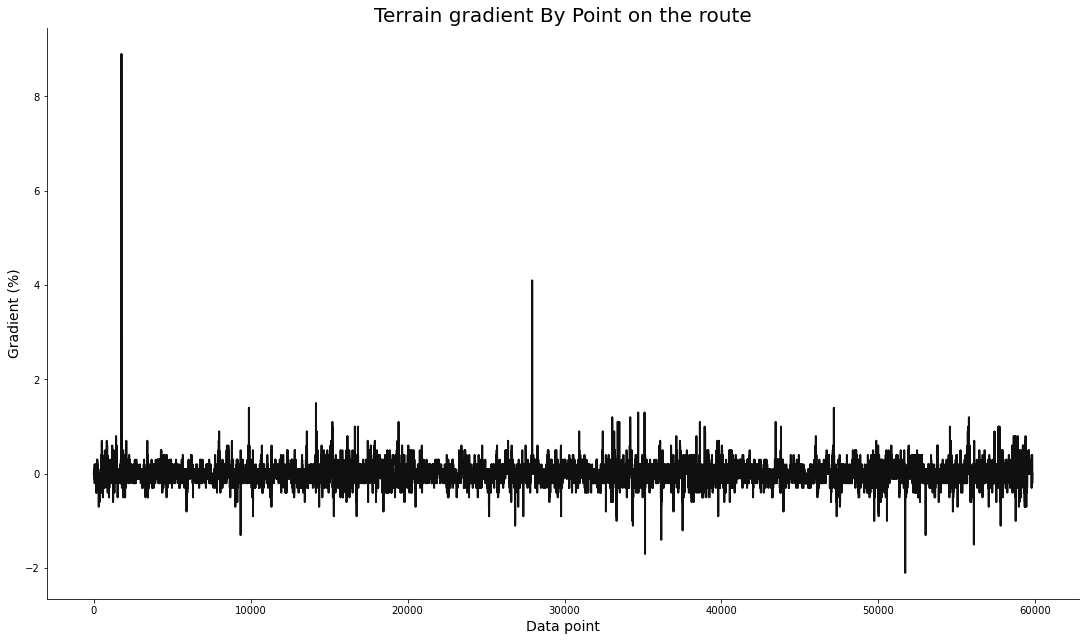

In [111]:
# gradient just from each step

conversion_factor = 0.62137119
gradient_each_point =[np.nan]
for ind, row in df.iterrows():
    if ind == 0:
        continue
    if (row['distance']/conversion_factor) == 0:
        gradient_each_point.append(0)
    else:
        grade = (row['elevation_change'] / (row['distance']/conversion_factor*1000))
    if row['moving_time'] == 0 :
        gradient_each_point.append(0)
    # if grade > cap_high :
    #     gradient_each_point.append(0)
    else:
        gradient_each_point.append(np.round(grade,1))
    

plt.figure(figsize=(18.5, 10.5))
plt.title('Terrain gradient By Point on the route', size=20)
plt.xlabel('Data point', size=14)
plt.ylabel('Gradient (%)', size=14)
plt.plot(np.arange(len(gradient_each_point)), gradient_each_point, lw=2, color='#101010');

In [106]:
df['gradient_each_point'] = gradient_each_point

df['euc_mph'].describe()

count    59640.000000
mean         4.066316
std          2.525913
min          0.000000
25%          2.906327
50%          3.935959
75%          5.036651
max        221.798116
Name: euc_mph, dtype: float64

In [107]:
prev = df['second'][0]
conversion_factor = 0.62137119
grade_section_speed =[]
grade_pace =[]
mile_marker = []

for i in range(len(df)):
    
    unit_speed = df['euc_mph'][i]
    if unit_speed == 0:
        unit_pace = 0
    else:
        unit_pace = str(datetime.timedelta(seconds=60/unit_speed*60))
    grade_section_speed.append(np.round(unit_speed,2))
    grade_pace.append(unit_pace)
    mile_marker.append(df['mile_num'][i])

In [108]:
d={'mile_number':mile_marker,'speed_mph':grade_section_speed,'pace':grade_pace,'gradient':gradient_each_point}
speed_grade = pd.DataFrame(data = d)
speed_grade.describe()

,mile_number,speed_mph,gradient
count,59640.000000,59640.000000,59639.0
mean,36.222938,4.066318,0.0
std,19.274242,2.525914,0.0
min,1.000000,0.000000,0.0
25%,20.000000,2.910000,0.0
50%,37.000000,3.940000,0.0
75%,53.000000,5.040000,0.0
max,68.000000,221.800000,0.0


In [99]:
moving_analysis = speed_grade[speed_grade['speed_mph'] > 2]
moving_analysis.describe()

,mile_number,speed_mph,gradient
count,4260.000000,4260.000000,4260.000000
mean,4.732160,7.110718,0.020728
std,2.336225,1.716577,0.822012
min,1.000000,2.090000,-4.500000
25%,3.000000,6.127500,-0.500000
50%,5.000000,7.340000,0.000000
75%,7.000000,8.080000,0.500000
max,9.000000,36.270000,5.200000


In [98]:
import altair as alt

selection = alt.selection_multi(fields=['mile_number'])


scatter = alt.Chart(moving_analysis).mark_point(size=50).encode(
    alt.X("gradient"),
    alt.Y("speed_mph"),
    alt.Color("mile_number",
                legend = alt.Legend(
                    title = "Mile Number",
                    orient = 'left',
                    titleFontSize=15,
                    labelFontSize=13)
                ),
    opacity = alt.condition(selection, alt.value(1),alt.value(0))
).properties(
    height=350, width=500
).configure_axis(
    titleFontSize=20,
    labelFontSize=15
).add_selection(
    selection
)

scatter


alt.Chart(...)

In [96]:
source = speed_grade

brush = alt.selection(type='interval')

points = alt.Chart(source).mark_point().encode(
    x='gradient:N',
    y='speed_mph:Q',
    color=alt.condition(brush, 'mile_number:N', alt.value('lightgray'))
).properties(
    height=350, width=800
).add_selection(
    brush
)

bars = alt.Chart(source).mark_bar().encode(
    y='mile_number:N',
    color='mile_number:N',
    x='count(mile_number):Q'
).transform_filter(
    brush
)

points & bars

alt.VConcatChart(...)

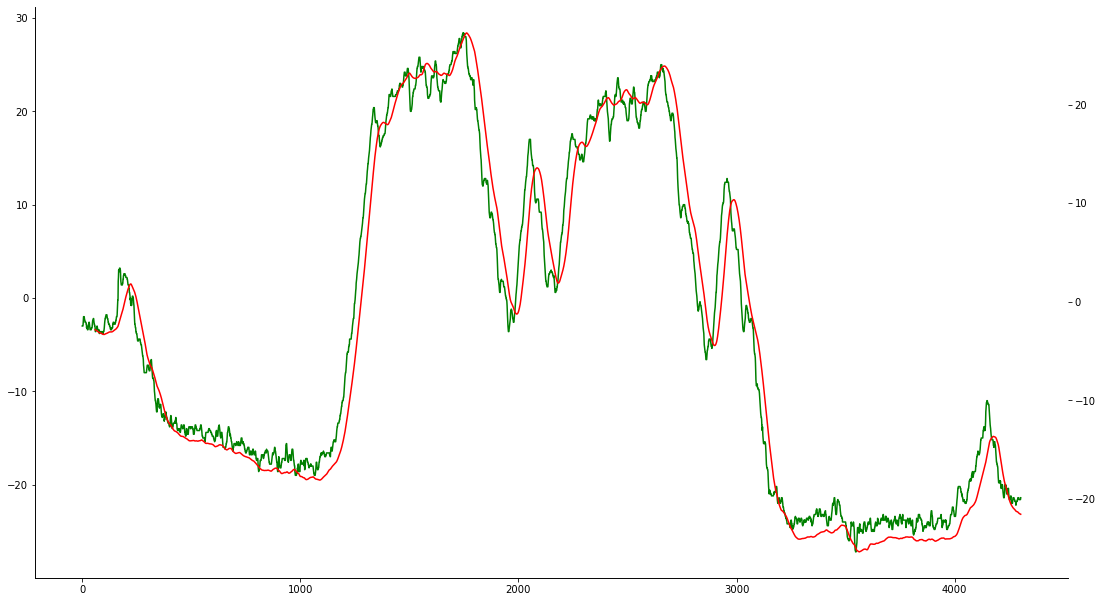

In [14]:
# Experiment with mean max and min on rolling elevation change
elv_period = 120
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax2 = ax1.twinx()
ax1.plot(df.index,df['elevation'], c='g')
ax2.plot(df.index,df['elevation'].rolling(60).mean(), c='r')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).max()[0:2000], c='r')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).min()[0:2000], c='b')